In [1]:
import collections
from functools import partial
import itertools
import json
import pathlib
import sys

import matplotlib
from matplotlib import pyplot as plt
import ml_collections
import numpy as np
import pandas as pd
import torch

import hier
import infer
import main
import metrics
import progmet
import tree_util

In [2]:
Experiment = collections.namedtuple('Experiment', ['config_file', 'model_file'])

def standard_experiment(experiment_dir, epoch):
    return Experiment(
        config_file=pathlib.Path(experiment_dir) / 'config.json',
        model_file=pathlib.Path(experiment_dir) / f'checkpoints/epoch-{epoch:04d}.pth',
    )

In [3]:
device = torch.device('cuda')

In [4]:
import configs.inaturalist2021mini

base_config = configs.inaturalist2021mini.get_config()
base_config.dataset_root = '/home/jack/data/manual/inaturalist2021/'

_, eval_dataset, _, _, _, eval_label_map = main.make_datasets(base_config)

In [5]:
eval_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=8)

In [71]:
PLOT_DIR = 'output/plots/ood-inat21mini-d7'
EXP_ROOT = pathlib.Path('/mnt/ssd1/projects/2022-01-hierarchical/experiments')
experiments = {
    'flat_softmax': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c',
        epoch=20),
#     'flat_softmax-old': standard_experiment(
#         experiment_dir=EXP_ROOT / '2022-04-11-inat21mini-partition/d7_n2_i0_c',
#         epoch=20),
    'hier_softmax': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-11-inat21mini-partition/d7_n2_i0_c-hier',
        epoch=20),
    'cond_multilabel': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-cond_multilabel',
        epoch=20),
    'share_random_cut': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-share_random_cut-0',
        epoch=20),
    'descendant_softmax': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax-bal',
        epoch=20),
    'descendant_softmax_complement': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-descendant_softmax_complement-bal',
        epoch=20),
    'soft_margin-incorrect-5': standard_experiment(
        experiment_dir=EXP_ROOT / '2022-04-20-inat21mini-partition/d7_n2_i0_c-soft_margin-incorrect-5',
        epoch=20),
}
hierarchy_files = {
    'full': 'resources/hierarchy/inat21.csv',
    'train': 'resources/subtree/inat21_partition_d7_n2_i0_c.csv',
    'trunc': 'resources/subtree/inat21_max_depth_6.csv',
}

method_titles = {
    'flat_softmax': 'Flat',
    # 'multilabel_focal': 'Multilabel (focal)',
    'hier_softmax': 'Cond softmax',
    'cond_multilabel': 'Cond sigmoid',
    'share_random_cut': 'Deep-RTC',
    'descendant_softmax': 'Soft-max-descendant',
    'descendant_softmax_complement': 'Soft-max-descendant (cousin)',
    'soft_margin-incorrect-5': 'Soft-max-margin (correct)',
}

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d6_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d6_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_5.csv',
# }

# experiments = {
#     'flat': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c/',
#         epoch=20),
#     'descendant': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax-bal/',
#         epoch=20),
#     'sibling': standard_experiment(
#         experiment_dir='/mnt/ssd1/projects/2022-01-hierarchical/experiments/2022-04-20-inat21mini-partition/d4_n2_i0_c-descendant_softmax_complement-bal/',
#         epoch=20),
# }
# hierarchy_files = {
#     'full': 'resources/hierarchy/inat21.csv',
#     'train': 'resources/subtree/inat21_partition_d4_n2_i0_c.csv',
#     'trunc': 'resources/subtree/inat21_max_depth_3.csv',
# }

In [61]:
colors = dict(zip(
    experiments,
    map(matplotlib.cm.get_cmap('tab10'), itertools.count())))

In [7]:
trees = {}
node_names = {}

for tree_name, hierarchy_file in hierarchy_files.items():
    with open(hierarchy_file) as f:
        trees[tree_name], node_names[tree_name] = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [45]:
# Precompute some things and define functions for each tree.

metric_fns = {}
infer_fns = {}
specificity = {}
is_leaf = {}
not_trivial = {}

for tree_name, tree in trees.items():
    info_metric = metrics.UniformLeafInfoMetric(tree)
    depth_metric = metrics.DepthMetric(tree)
    metric_fns[tree_name] = {
        'exact': lambda gt, pr: pr == gt,
        'correct': metrics.IsCorrect(tree),
        'info_excess': info_metric.excess,
        'info_deficient': info_metric.deficient,
        'info_dist': info_metric.dist,
        'info_recall': info_metric.recall,
        'info_precision': info_metric.precision,
        'depth_excess': depth_metric.excess,
        'depth_deficient': depth_metric.deficient,
        'depth_dist': depth_metric.dist,
        'depth_recall': depth_metric.recall,
        'depth_precision': depth_metric.precision,
    }

    is_leaf[tree_name] = tree.leaf_mask()
    specificity[tree_name] = -tree.num_leaf_descendants()
    not_trivial[tree_name] = (tree.num_children() != 1)

    infer_fns[tree_name] = {
        'leaf': partial(
            infer.argmax_where, condition=is_leaf[tree_name]),
        'majority': partial(
            infer.argmax_with_confidence, specificity[tree_name],
            threshold=0.5, condition=not_trivial[tree_name]),
    }


metric_titles = {
    'exact': 'Exact',
    'correct': 'Correct',
    'info_recall': 'Information Recall',
    'info_precision': 'Information Precision',
    'depth_recall': 'Depth Recall',
    'depth_precision': 'Depth Precision',
    'info_lca': 'LCA Information',
    'depth_lca': 'LCA Depth',
}

markers = {
    'leaf': 'o',
    'majority': '^',
}

In [9]:
node_subsets = {}
for tree_name in trees:
    node_subsets[tree_name] = hier.find_subset_index(node_names['full'], node_names[tree_name])
node_subsets

{'full': array([    0,     1,     2, ..., 16341, 16342, 16343]),
 'train': array([    0,     1,     2, ..., 16335, 16336, 16337]),
 'trunc': array([    0,     1,     2, ..., 16340, 16341, 16342])}

In [10]:
def apply_model(net, pred_fn, min_threshold, limit=None):
    # Per-example predictions.

    outputs = {
        'gt': [],  # Node in hierarchy.
        'pred': {tree_name: {method: [] for method in infer_fns[tree_name]} for tree_name in trees},
    }
    # Sequence-per-example predictions. Cannot be concatenated due to ragged shape.
    seq_outputs = {
        'pred': {tree_name: [] for tree_name in trees},
        'prob': {tree_name: [] for tree_name in trees},
    }

    net.eval()
    with torch.inference_mode():
        meter = progmet.ProgressMeter('apply', interval_time=5)
        for minibatch in itertools.islice(meter(eval_loader), limit):
            inputs, gt_labels = minibatch
            theta = net(inputs.to(device))
            # Get distribution on training subtree.
            prob = {}
            prob['train'] = pred_fn(theta).cpu().numpy()
            # Get distribution on full subtree (pad with zeros).
            prob['full'] = np.zeros((inputs.shape[0], trees['full'].num_nodes()), dtype=np.float32)
            prob['full'][:, node_subsets['train']] = prob['train']
            # Get distribution on truncated subtree.
            prob['trunc'] = prob['full'][..., node_subsets['trunc']]

            gt_node = eval_label_map.to_node[gt_labels]
            # Caution: Predictions are *not* truncated.
            pred = {}
            pred_seqs = {}
            prob_seqs = {}
            for tree_name in trees:
                pred[tree_name] = {}
                for infer_name, infer_fn in infer_fns[tree_name].items():
                    pred[tree_name][infer_name] = infer_fn(prob[tree_name])
                pred_seqs[tree_name] = [
                    infer.pareto_optimal_predictions(
                        specificity[tree_name], p, min_threshold, not_trivial[tree_name])
                    for p in prob[tree_name]
                ]
                prob_seqs[tree_name] = [prob[tree_name][i, pred_i] for i, pred_i in enumerate(pred_seqs[tree_name])]

            outputs['gt'].append(gt_node)
            for tree_name in trees:
                for method in infer_fns[tree_name]:
                    outputs['pred'][tree_name][method].append(pred[tree_name][method])
                seq_outputs['pred'][tree_name].extend(pred_seqs[tree_name])
                seq_outputs['prob'][tree_name].extend(prob_seqs[tree_name])

    # Concatenate results from minibatches.
    leaf_predicate = lambda x: not isinstance(x, dict)  # Treat lists as values, not containers.
    outputs = tree_util.tree_map(np.concatenate, outputs, is_leaf=leaf_predicate)

    return outputs, seq_outputs

In [11]:
def assess_predictions(outputs, seq_outputs):
    pred_metrics = {}
    pareto_scores = {}
    pareto_means = {}

    # Evaluate predictions for each method and for each subset of examples.
    for tree_name in outputs['pred'].keys():
        tree = trees[tree_name]
        project = hier.find_projection(trees['full'], node_subsets[tree_name])
        gt = project[outputs['gt']]
        pred = outputs['pred'][tree_name]
        pred_seq = seq_outputs['pred'][tree_name]
        prob_seq = seq_outputs['prob'][tree_name]
        pred = {
            method: hier.truncate_at_lca(tree, gt, pr)
            for method, pr in pred.items()
        }
        pred_metrics[tree_name] = {
            method: {
                field: np.mean(metric_fn(gt, pr))
                for field, metric_fn in metric_fns[tree_name].items()
            } for method, pr in pred.items()
        }

        # Evaluate predictions in Pareto sequence.
        find_lca = hier.FindLCA(tree)
        pred_seq = [hier.truncate_given_lca(gt_i, pr_i, find_lca(gt_i, pr_i)) for gt_i, pr_i in zip(gt, pred_seq)]
        metric_values_seq = {
            field: [metric_fn(gt_i, pr_i) for gt_i, pr_i in zip(gt, pred_seq)]
            for field, metric_fn in metric_fns[tree_name].items()
        }
        pareto_scores[tree_name], pareto_totals = metrics.operating_curve(prob_seq, metric_values_seq)
        pareto_means[tree_name] = {k: v / len(gt) for k, v in pareto_totals.items()}

    return pred_metrics, pareto_scores, pareto_means

In [12]:
# Initialize results if not defined.
try:
    results
except NameError:
    results = {}  # Not defined.

In [13]:
MIN_THRESHOLD = None  # Values less than 0.5 may increase runtime significantly.
LIMIT = None

for name, (config_file, model_file) in experiments.items():
    if name in results:
        print('cached:', name)
        continue

    # Load model.
    with open(config_file, 'r') as f:
        config = ml_collections.ConfigDict(json.load(f))
    num_outputs = main.get_num_outputs(config.predict, trees['train'])
    net = main.make_model(config.model, num_outputs)
    missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_file), strict=True)
    assert not missing_keys
    assert not unexpected_keys

    net.to(device)
    _, pred_fn = main.make_loss(config, trees['train'], device)
    outputs, seq_outputs = apply_model(net, pred_fn, min_threshold=MIN_THRESHOLD, limit=LIMIT)

    example_masks = {
        'seen': np.isin(outputs['gt'], node_subsets['train']),
        'unseen': np.isin(outputs['gt'], node_subsets['train'], invert=True),
        'all': None,
    }

    pred_metrics = {}
    pareto_scores = {}
    pareto_metrics = {}
    for subset_name, example_mask in example_masks.items():
        print('evaluate:', subset_name, file=sys.stderr)
        if example_mask is None:
            subset_outputs = outputs
            subset_seq_outputs = seq_outputs
        else:
            example_subset, = np.nonzero(example_mask)
            subset_outputs = tree_util.tree_map(lambda x: x[example_mask], outputs)
            subset_seq_outputs = {
                'pred': {tree_name: [seq_outputs['pred'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['pred']},
                'prob': {tree_name: [seq_outputs['prob'][tree_name][i] for i in example_subset]
                         for tree_name in seq_outputs['prob']},
            }
        pred_metrics[subset_name], pareto_scores[subset_name], pareto_metrics[subset_name] = (
            assess_predictions(subset_outputs, subset_seq_outputs))

    results[name] = {
        'pred_metrics': pred_metrics,
        'pareto_scores': pareto_scores,
        'pareto_metrics': pareto_metrics,
    }

apply:   1% (4/391); T=1.31 f=0.762; mean T=1.31 f=0.762; elapsed 0:00:05; remaining 0:08:28 of 0:08:33
apply:   3% (10/391); T=0.922 f=1.08; mean T=1.08 f=0.928; elapsed 0:00:11; remaining 0:06:51 of 0:07:02
apply:   4% (16/391); T=0.910 f=1.10; mean T=1.02 f=0.985; elapsed 0:00:16; remaining 0:06:21 of 0:06:37
apply:   6% (22/391); T=0.914 f=1.09; mean T=0.987 f=1.01; elapsed 0:00:22; remaining 0:06:04 of 0:06:26
apply:   7% (28/391); T=0.926 f=1.08; mean T=0.974 f=1.03; elapsed 0:00:27; remaining 0:05:54 of 0:06:21
apply:   9% (34/391); T=0.920 f=1.09; mean T=0.965 f=1.04; elapsed 0:00:33; remaining 0:05:44 of 0:06:17
apply:  10% (40/391); T=0.929 f=1.08; mean T=0.959 f=1.04; elapsed 0:00:38; remaining 0:05:37 of 0:06:15
apply:  12% (46/391); T=0.925 f=1.08; mean T=0.955 f=1.05; elapsed 0:00:44; remaining 0:05:29 of 0:06:13
apply:  13% (52/391); T=0.928 f=1.08; mean T=0.952 f=1.05; elapsed 0:00:49; remaining 0:05:23 of 0:06:12
apply:  15% (58/391); T=0.917 f=1.09; mean T=0.948 f=1.0

apply:  19% (76/391); T=0.898 f=1.11; mean T=0.937 f=1.07; elapsed 0:01:11; remaining 0:04:55 of 0:06:06
apply:  21% (82/391); T=0.895 f=1.12; mean T=0.934 f=1.07; elapsed 0:01:17; remaining 0:04:49 of 0:06:05
apply:  23% (88/391); T=0.908 f=1.10; mean T=0.932 f=1.07; elapsed 0:01:22; remaining 0:04:42 of 0:06:05
apply:  24% (94/391); T=0.952 f=1.05; mean T=0.934 f=1.07; elapsed 0:01:28; remaining 0:04:37 of 0:06:05
apply:  26% (100/391); T=0.928 f=1.08; mean T=0.933 f=1.07; elapsed 0:01:33; remaining 0:04:32 of 0:06:05
apply:  27% (106/391); T=0.934 f=1.07; mean T=0.933 f=1.07; elapsed 0:01:39; remaining 0:04:26 of 0:06:05
apply:  29% (112/391); T=0.945 f=1.06; mean T=0.934 f=1.07; elapsed 0:01:45; remaining 0:04:21 of 0:06:05
apply:  30% (118/391); T=0.920 f=1.09; mean T=0.933 f=1.07; elapsed 0:01:50; remaining 0:04:15 of 0:06:05
apply:  32% (124/391); T=0.902 f=1.11; mean T=0.932 f=1.07; elapsed 0:01:56; remaining 0:04:09 of 0:06:04
apply:  33% (130/391); T=0.902 f=1.11; mean T=0.93

apply:  37% (144/391); T=0.967 f=1.03; mean T=0.979 f=1.02; elapsed 0:02:21; remaining 0:04:02 of 0:06:23
apply:  38% (150/391); T=0.960 f=1.04; mean T=0.978 f=1.02; elapsed 0:02:27; remaining 0:03:56 of 0:06:22
apply:  40% (156/391); T=0.916 f=1.09; mean T=0.975 f=1.03; elapsed 0:02:32; remaining 0:03:49 of 0:06:21
apply:  41% (162/391); T=0.939 f=1.07; mean T=0.974 f=1.03; elapsed 0:02:38; remaining 0:03:43 of 0:06:21
apply:  43% (168/391); T=0.946 f=1.06; mean T=0.973 f=1.03; elapsed 0:02:43; remaining 0:03:37 of 0:06:20
apply:  45% (174/391); T=0.938 f=1.07; mean T=0.972 f=1.03; elapsed 0:02:49; remaining 0:03:31 of 0:06:20
apply:  46% (180/391); T=0.956 f=1.05; mean T=0.971 f=1.03; elapsed 0:02:55; remaining 0:03:25 of 0:06:20
apply:  48% (186/391); T=0.937 f=1.07; mean T=0.970 f=1.03; elapsed 0:03:00; remaining 0:03:19 of 0:06:19
apply:  49% (192/391); T=0.922 f=1.08; mean T=0.969 f=1.03; elapsed 0:03:06; remaining 0:03:13 of 0:06:19
apply:  51% (198/391); T=0.948 f=1.05; mean T=

apply:  50% (195/391); T=0.969 f=1.03; mean T=1.01 f=0.987; elapsed 0:03:18; remaining 0:03:19 of 0:06:36
apply:  51% (201/391); T=0.972 f=1.03; mean T=1.01 f=0.989; elapsed 0:03:23; remaining 0:03:12 of 0:06:36
apply:  53% (207/391); T=0.951 f=1.05; mean T=1.01 f=0.990; elapsed 0:03:29; remaining 0:03:06 of 0:06:35
apply:  54% (213/391); T=0.967 f=1.03; mean T=1.01 f=0.991; elapsed 0:03:35; remaining 0:03:00 of 0:06:34
apply:  56% (219/391); T=0.999 f=1.00; mean T=1.01 f=0.992; elapsed 0:03:41; remaining 0:02:53 of 0:06:34
apply:  58% (225/391); T=0.991 f=1.01; mean T=1.01 f=0.992; elapsed 0:03:47; remaining 0:02:47 of 0:06:34
apply:  59% (230/391); T=1.01 f=0.986; mean T=1.01 f=0.992; elapsed 0:03:52; remaining 0:02:42 of 0:06:34
apply:  60% (235/391); T=1.04 f=0.966; mean T=1.01 f=0.991; elapsed 0:03:57; remaining 0:02:37 of 0:06:34
apply:  61% (240/391); T=1.02 f=0.985; mean T=1.01 f=0.991; elapsed 0:04:02; remaining 0:02:32 of 0:06:34
apply:  63% (246/391); T=0.972 f=1.03; mean T=

apply:  54% (212/391); T=1.02 f=0.981; mean T=1.14 f=0.881; elapsed 0:04:01; remaining 0:03:23 of 0:07:24
apply:  55% (217/391); T=1.02 f=0.982; mean T=1.13 f=0.883; elapsed 0:04:06; remaining 0:03:17 of 0:07:23
apply:  57% (222/391); T=1.03 f=0.967; mean T=1.13 f=0.885; elapsed 0:04:11; remaining 0:03:11 of 0:07:22
apply:  58% (227/391); T=1.03 f=0.976; mean T=1.13 f=0.886; elapsed 0:04:16; remaining 0:03:05 of 0:07:21
apply:  59% (232/391); T=1.02 f=0.983; mean T=1.13 f=0.888; elapsed 0:04:21; remaining 0:02:59 of 0:07:20
apply:  61% (237/391); T=1.02 f=0.985; mean T=1.12 f=0.890; elapsed 0:04:26; remaining 0:02:53 of 0:07:19
apply:  62% (243/391); T=1.00 f=0.999; mean T=1.12 f=0.893; elapsed 0:04:32; remaining 0:02:46 of 0:07:18
apply:  63% (248/391); T=1.01 f=0.989; mean T=1.12 f=0.894; elapsed 0:04:37; remaining 0:02:40 of 0:07:17
apply:  65% (253/391); T=1.03 f=0.970; mean T=1.12 f=0.896; elapsed 0:04:42; remaining 0:02:34 of 0:07:17
apply:  66% (258/391); T=1.05 f=0.956; mean T=

apply:  53% (206/391); T=1.12 f=0.890; mean T=1.13 f=0.882; elapsed 0:03:54; remaining 0:03:30 of 0:07:24
apply:  54% (211/391); T=1.18 f=0.849; mean T=1.14 f=0.881; elapsed 0:04:00; remaining 0:03:24 of 0:07:24
apply:  55% (215/391); T=1.39 f=0.718; mean T=1.14 f=0.877; elapsed 0:04:05; remaining 0:03:21 of 0:07:26
apply:  56% (219/391); T=1.28 f=0.782; mean T=1.14 f=0.875; elapsed 0:04:10; remaining 0:03:17 of 0:07:27
apply:  57% (224/391); T=1.22 f=0.819; mean T=1.14 f=0.874; elapsed 0:04:16; remaining 0:03:11 of 0:07:27
apply:  59% (229/391); T=1.21 f=0.827; mean T=1.15 f=0.873; elapsed 0:04:22; remaining 0:03:06 of 0:07:28
apply:  60% (234/391); T=1.12 f=0.896; mean T=1.15 f=0.873; elapsed 0:04:28; remaining 0:03:00 of 0:07:28
apply:  61% (239/391); T=1.18 f=0.850; mean T=1.15 f=0.873; elapsed 0:04:34; remaining 0:02:54 of 0:07:28
apply:  62% (244/391); T=1.20 f=0.833; mean T=1.15 f=0.872; elapsed 0:04:40; remaining 0:02:49 of 0:07:28
apply:  64% (249/391); T=1.16 f=0.862; mean T=

apply:  50% (197/391); T=1.21 f=0.829; mean T=1.13 f=0.882; elapsed 0:03:43; remaining 0:03:40 of 0:07:23
apply:  52% (202/391); T=1.19 f=0.838; mean T=1.13 f=0.881; elapsed 0:03:49; remaining 0:03:35 of 0:07:24
apply:  53% (207/391); T=1.21 f=0.829; mean T=1.14 f=0.880; elapsed 0:03:55; remaining 0:03:29 of 0:07:24
apply:  54% (212/391); T=1.14 f=0.874; mean T=1.14 f=0.880; elapsed 0:04:01; remaining 0:03:23 of 0:07:25
apply:  55% (217/391); T=1.14 f=0.878; mean T=1.14 f=0.880; elapsed 0:04:07; remaining 0:03:18 of 0:07:25
apply:  57% (222/391); T=1.17 f=0.856; mean T=1.14 f=0.879; elapsed 0:04:13; remaining 0:03:12 of 0:07:25
apply:  58% (227/391); T=1.17 f=0.851; mean T=1.14 f=0.878; elapsed 0:04:18; remaining 0:03:07 of 0:07:25
apply:  59% (232/391); T=1.15 f=0.870; mean T=1.14 f=0.878; elapsed 0:04:24; remaining 0:03:01 of 0:07:25
apply:  61% (237/391); T=1.17 f=0.857; mean T=1.14 f=0.878; elapsed 0:04:30; remaining 0:02:55 of 0:07:25
apply:  62% (242/391); T=1.16 f=0.861; mean T=

In [14]:
# Majority prediction in full tree.
# Rewards method for not being too confident about leaf nodes.
# However, this was not something that was represented in the objective?
# It's ok to use though.. just need to plot curves!

pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

correct                     info_recall  \
                                   all      seen    unseen         all   
flat_softmax                   0.72593  0.840825  0.610159    0.463172   
hier_softmax                   0.67895  0.774557  0.582614    0.438079   
cond_multilabel                0.73033  0.803606  0.656495    0.416130   
share_random_cut               0.29068  0.579159  0.000000    0.566469   
descendant_softmax             0.78242  0.857900  0.706364    0.420240   
descendant_softmax_complement  0.77258  0.857362  0.687151    0.434420   
soft_margin-incorrect-5        0.58747  0.780295  0.393174    0.507183   

                                                   
                                   seen    unseen  
flat_softmax                   0.594218  0.331127  
hier_softmax                   0.523966  0.351536  
cond_multilabel                0.494789  0.336870  
share_random_cut               0.720832  0.410928  
descendant_softmax             0.513514  0.326254  
descendant_softmax_complement  0.532132  0.335963  
soft_margin-incorrect-5        0.657321  0.355900

In [55]:
# Majority prediction in truncated tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['trunc']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [58]:
# Majority prediction in training tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['train']['majority'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [59]:
# Leaf prediction in full tree.

table = pd.DataFrame({field: {
    (loss, subset): results[loss]['pred_metrics'][subset]['full']['leaf'][field]
    for loss in results
    for subset in results[loss]['pred_metrics']
} for field in ['correct', 'info_recall']}).unstack().loc[list(experiments.keys())]

table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [72]:
# Get integrals!

INTEGRALS = {
    'AP(info)': ('info_recall', 'info_precision'),
    'AC(info)': ('info_recall', 'correct'),
    'AC(exact)': ('exact', 'correct'),
    'AP(depth)': ('depth_recall', 'depth_precision'),
    'AC(depth)': ('depth_recall', 'correct'),
}

auc = {
    integral_key: {
        (tree_name, name, subset_name): metrics.pareto_integrate(
            results[name]['pareto_metrics'][subset_name][tree_name][x],
            results[name]['pareto_metrics'][subset_name][tree_name][y])
        for tree_name in trees
        for name in experiments if name in results
        for subset_name in ['all', 'seen', 'unseen']
    } for integral_key, (x, y) in INTEGRALS.items()
}

auc = pd.DataFrame(auc).unstack()
# auc = auc.set_index(auc.index.map(method_titles))
auc.style.format(lambda x: f'{x * 100:.1f}')

In [74]:
table = auc.loc['train']
table = table.loc[list(experiments)]  # Restore order?
table = table.set_index(table.index.map(method_titles))
table.style.format(lambda x: f'{x * 100:.1f}')

In [77]:
print(table['AC(info)'].style.format(lambda x: f'{x * 100:.1f}').to_latex())

\begin{tabular}{lrrr}
 & all & seen & unseen \\
Flat & 57.2 & 67.5 & 47.4 \\
Cond softmax & 54.6 & 60.5 & 49.3 \\
Cond sigmoid & 54.2 & 60.1 & 48.9 \\
Deep-RTC & 52.6 & 63.8 & 41.3 \\
Soft-max-descendant & 55.7 & 65.3 & 47.2 \\
Soft-max-descendant (cousin) & 56.2 & 66.1 & 47.4 \\
Soft-max-margin (correct) & 57.4 & 68.7 & 46.3 \\
\end{tabular}



In [78]:
print(table['AP(info)'].style.format(lambda x: f'{x * 100:.1f}').to_latex())

\begin{tabular}{lrrr}
 & all & seen & unseen \\
Flat & 59.2 & 69.3 & 49.5 \\
Cond softmax & 57.3 & 63.4 & 51.6 \\
Cond sigmoid & 56.9 & 63.1 & 51.1 \\
Deep-RTC & 57.1 & 68.1 & 46.0 \\
Soft-max-descendant & 58.0 & 67.6 & 49.2 \\
Soft-max-descendant (cousin) & 58.3 & 68.1 & 49.2 \\
Soft-max-margin (correct) & 59.1 & 70.0 & 48.3 \\
\end{tabular}



In [79]:
print(table['AC(exact)'].style.format(lambda x: f'{x * 100:.1f}').to_latex())

\begin{tabular}{lrrr}
 & all & seen & unseen \\
Flat & 36.7 & 50.8 & 23.5 \\
Cond softmax & 31.0 & 38.9 & 24.1 \\
Cond sigmoid & 30.3 & 38.4 & 23.4 \\
Deep-RTC & 38.1 & 51.2 & 25.3 \\
Soft-max-descendant & 31.4 & 43.7 & 21.8 \\
Soft-max-descendant (cousin) & 32.1 & 44.9 & 22.0 \\
Soft-max-margin (correct) & 38.7 & 54.0 & 23.9 \\
\end{tabular}



In [46]:
def plot_metrics(tree_name, subset_name, x, y, tickres=None, is_pr=True, save=False):
    plt.figure(figsize=(5, 4))
    for name in experiments:
        if name not in results:
            continue
        pred_metrics = results[name]['pred_metrics'][subset_name][tree_name]
        pareto_scores = results[name]['pareto_scores'][subset_name][tree_name]
        pareto_metrics = results[name]['pareto_metrics'][subset_name][tree_name]
        ge = np.concatenate(([True], pareto_scores >= 0.5))
        le = np.concatenate(([False], pareto_scores <= 0.5))
        plt.plot(pareto_metrics[x][ge], pareto_metrics[y][ge],
                 color=colors[name], label=method_titles.get(name, name))
        plt.plot(pareto_metrics[x][le], pareto_metrics[y][le],
                 color=colors[name], linestyle='--')
        for method, method_metrics in pred_metrics.items():
            plt.plot(method_metrics[x], method_metrics[y], color=colors[name],
                     marker=markers[method], markerfacecolor='none')

    ax = plt.gca()
    if is_pr:
        plt.xlim(left=0)
        plt.ylim(top=1)
    if tickres:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tickres))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(tickres))
    plt.grid()
    plt.xlabel(metric_titles.get(x, x))
    plt.ylabel(metric_titles.get(y, y))

    if save:
        pathlib.Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{tree_name}-{subset_name}-{x}-{y}.pdf')
        plt.legend()
        plt.savefig(pathlib.Path(PLOT_DIR) / f'{tree_name}-{subset_name}-{x}-{y}-with-legend.pdf')
    else:
        plt.legend()

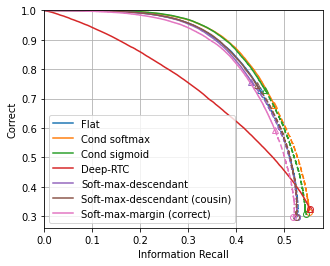

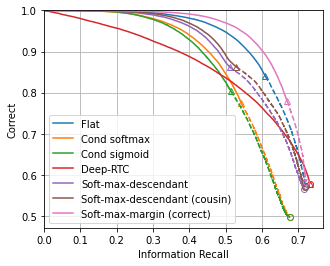

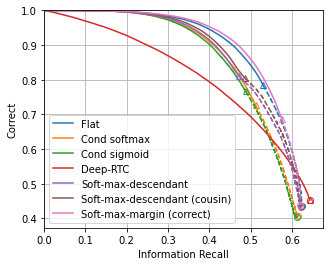

In [47]:
plot_metrics('train', 'unseen', 'info_recall', 'correct', save=True)
plt.show()
plot_metrics('train', 'seen', 'info_recall', 'correct', save=True)
plt.show()
plot_metrics('train', 'all', 'info_recall', 'correct', save=True)

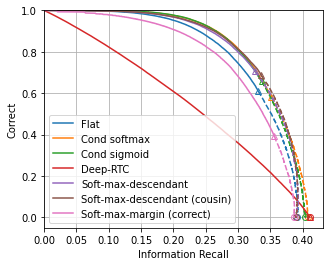

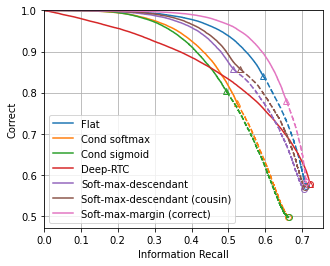

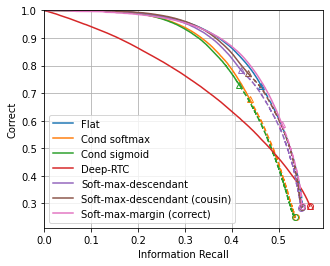

In [48]:
# Same for "full" tree (i.e. reward for not going to leaf node).

plot_metrics('full', 'unseen', 'info_recall', 'correct', save=True)
plt.show()
plot_metrics('full', 'seen', 'info_recall', 'correct', save=True)
plt.show()
plot_metrics('full', 'all', 'info_recall', 'correct', save=True)

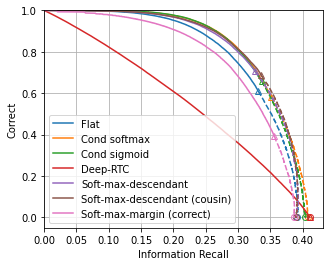

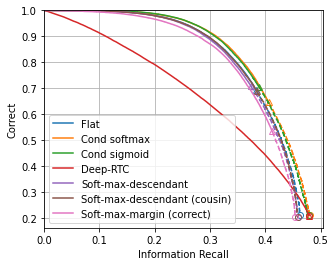

In [49]:
# Check the trade-off for unseen examples using metrics in the "train" and "trunc" subtrees.
# These give no penalty for predicting a leaf node under the nearest projected ancestor.
# (In fact, the prediction will be truncated at the ground-truth.)

plot_metrics('full', 'unseen', 'info_recall', 'correct', save=True)
plt.show()
plot_metrics('trunc', 'unseen', 'info_recall', 'correct', save=True)

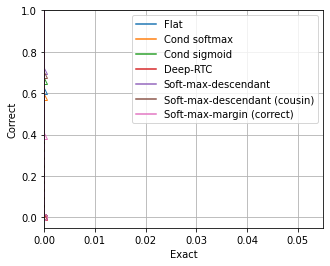

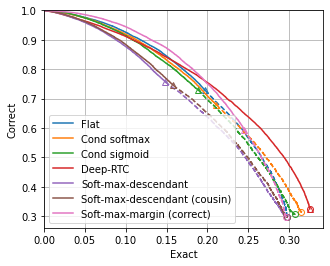

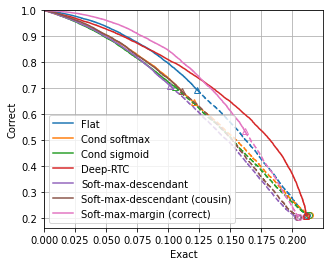

In [50]:
# Cannot plot correct-exact for unseen classes in full tree -- none will be exact.
# See how it looks in train/trunc trees.
# This requires the algorithm to predict the projected node, not a descendant.

plot_metrics('full', 'unseen', 'exact', 'correct', save=False)
plt.show()
plot_metrics('train', 'unseen', 'exact', 'correct', save=False)
plt.show()
plot_metrics('trunc', 'unseen', 'exact', 'correct', save=False)

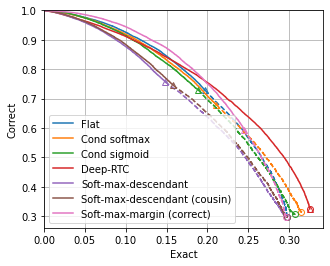

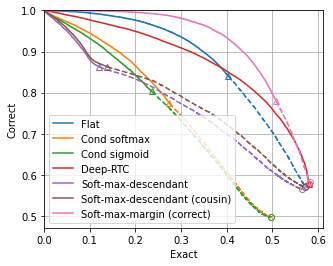

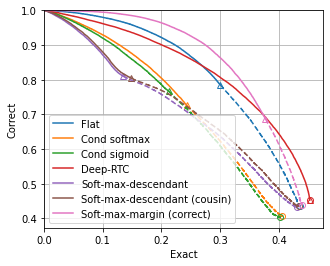

In [51]:
for subset_name in ['unseen', 'seen', 'all']:
    plot_metrics('train', subset_name, 'exact', 'correct', save=True)

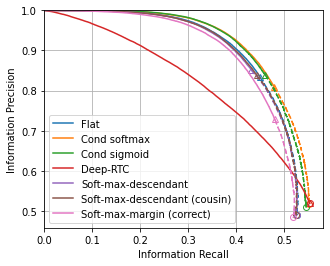

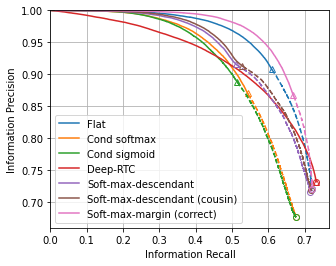

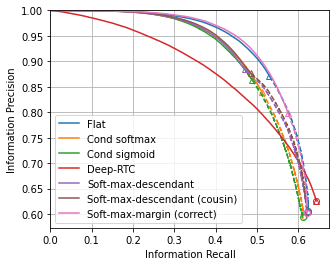

In [52]:
for subset_name in ['unseen', 'seen', 'all']:
    plot_metrics('train', subset_name, x, y, save=True)